In [1]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)

library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
options(warn=-1)
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(broom)

library(logistf)
library(ggfortify)
library(rpart)
library(rpart.plot)
library(arules)
source("../../../../src/ggstyles.R")
source("../../../../src/tools.R")
source("../../../script_figures/tools.R")




Attaching package: ‘dplyr’

The following object is masked from ‘package:matrixStats’:

    count

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2

Attaching package: ‘survival’

The following object is masked from ‘package:clusterCrit’:

    concordance

corrplot 0.84 loaded
Loading required package: lattice
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: ggpubr
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:rlang’:

    set_names

Loading required package: Matrix
Loading required package: foreach
Loaded g

In [2]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,c(cols_to_keep)],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD2 <- as.character(df_merge$MRD2)
df_merge <- df_merge[grep("17-", df_merge$AMLID),]   ### keep only AML 17
df_merge$CR_MRD_neg <- ifelse(df_merge$MRD2=="CR,MRD-",1,0)
df_merge[is.na(df_merge$CR_MRD_neg),"CR_MRD_neg"] <- 0
df_merge$CR_MRD_pos <- ifelse(df_merge$MRD2=="CR,MRD+",1,0)
df_merge[is.na(df_merge$CR_MRD_pos),"CR_MRD_pos"] <- 0
df_merge$all_others <- ifelse((df_merge$CR_MRD_pos==0 & df_merge$CR_MRD_neg==0),1,0)
df_merge <- df_merge[!is.na(df_merge$OS_CR),]
df_merge <- df_merge[!is.na(df_merge$MRD1),]   ## we do it based on MRD1 to have exactly same patients in the comparison post course 1 vs post course 2 study!!!
df_merge <- df_merge[df_merge$os >0 & df_merge$OS_CR >0 & df_merge$RFSyears>0,]


eln <- colnames(df_merge[,c(2,3,4)])

# remove comp always0 in df_merge otherwise 
age <- c(167)

genes<- colnames(df_merge[,c(5:88)])

cytos <- colnames(df_merge[,c(89:158)])       
              
clin <- colnames(df_merge[,c(159:165)])
demo <- colnames(df_merge[,c(166:167)])
mrd <- colnames(df_merge[,c(227,228,229)])

all_gen <- c(5:88)
vect <- apply(X=df_merge[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_merge)[1])
gen <- colnames(df_merge[,match(names(vect[vect>=2]),names(df_merge))])

all_cyto <- c(89:158)
vect <- apply(X=df_merge[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_merge)[1])
cyto <- colnames(df_merge[,match(names(vect[vect>=2]),names(df_merge))])
              
comp <- colnames(df_merge[,c(170:186)])
comp <- comp[colSums(df_merge[,comp])>0]
val <- c("#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#a6bddb","#fdbb84","#e79f00","#000000","darkseagreen","lightskyblue","#0072B2","pink","blue","green")

In [3]:
table(df_merge$CR_MRD_neg)


  0   1 
561 182 

# I) MRD Negative Predictors

# 1) COMPONENTS

# A) Association Rule Learning

In [69]:
tmp <- df_merge[,c(comp,"CR_MRD_neg")]
tmp$no_CR_MRD_neg <- ifelse(tmp$CR_MRD_neg==0,1,0)
tmp$CR_MRD_neg <- NULL
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{no_CR_MRD_neg}" & ruledf$lift >1 & ruledf$confidence >=0.8,]
colnames(ruledf)[colnames(ruledf) %in% c("lhs","rhs")] <- c("Rules","Target")


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[18 item(s), 744 transaction(s)] done [0.00s].
sorting and recoding items ... [14 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [52 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [70]:
head(ruledf[order(ruledf$lift,decreasing=T),],10)

,Rules,Target,support,confidence,lift,count
32,"{full_component_additions,full_component_chr_splicing_multiple}",{no_CR_MRD_neg},0.01747312,0.9285714,1.231474,13
51,"{full_component_additions,full_component_chr_splicing_multiple,overlap}",{no_CR_MRD_neg},0.01747312,0.9285714,1.231474,13
4,{full_component_t_11},{no_CR_MRD_neg},0.03897849,0.8529412,1.131173,29
14,{full_component_TP53_complex},{no_CR_MRD_neg},0.06854839,0.8500000,1.127273,51
15,{full_component_chr_splicing_multiple},{no_CR_MRD_neg},0.13575269,0.8416667,1.116221,101
33,"{full_component_additions,overlap}",{no_CR_MRD_neg},0.04973118,0.8409091,1.115216,37
30,"{full_component_additions,full_component_TP53_complex}",{no_CR_MRD_neg},0.02688172,0.8333333,1.105169,20
47,"{full_component_additions,full_component_TP53_complex,overlap}",{no_CR_MRD_neg},0.02688172,0.8333333,1.105169,20
12,{full_component_additions},{no_CR_MRD_neg},0.05645161,0.8235294,1.092167,42
3,{full_component_WT1},{no_CR_MRD_neg},0.02822581,0.8076923,1.071164,21


In [72]:
tmp <- df_merge[,c(comp,"CR_MRD_neg")]
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.3,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{CR_MRD_neg}",]
colnames(ruledf)[colnames(ruledf) %in% c("lhs","rhs")] <- c("Rules","Target")

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[18 item(s), 744 transaction(s)] done [0.00s].
sorting and recoding items ... [14 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [37 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [73]:
head(ruledf[order(ruledf$lift,decreasing=T),],10)

,Rules,Target,support,confidence,lift,count
3,{full_component_t_8_21},{CR_MRD_neg},0.02553763,0.4130435,1.688485,19
4,{full_component_inv_16},{CR_MRD_neg},0.02553763,0.4130435,1.688485,19
2,{full_component_CEBPA_bi},{CR_MRD_neg},0.01478495,0.4074074,1.665446,11
7,{full_component_chr_splicing_1},{CR_MRD_neg},0.02419355,0.3103448,1.268662,18


# B) Univariate and Multivariate Regression

In [74]:
table(df_merge$CR_MRD_neg)
table(df_merge$CR_MRD_pos)
table(df_merge$all_others)


  0   1 
561 182 


  0   1 
630 113 


  0   1 
295 448 

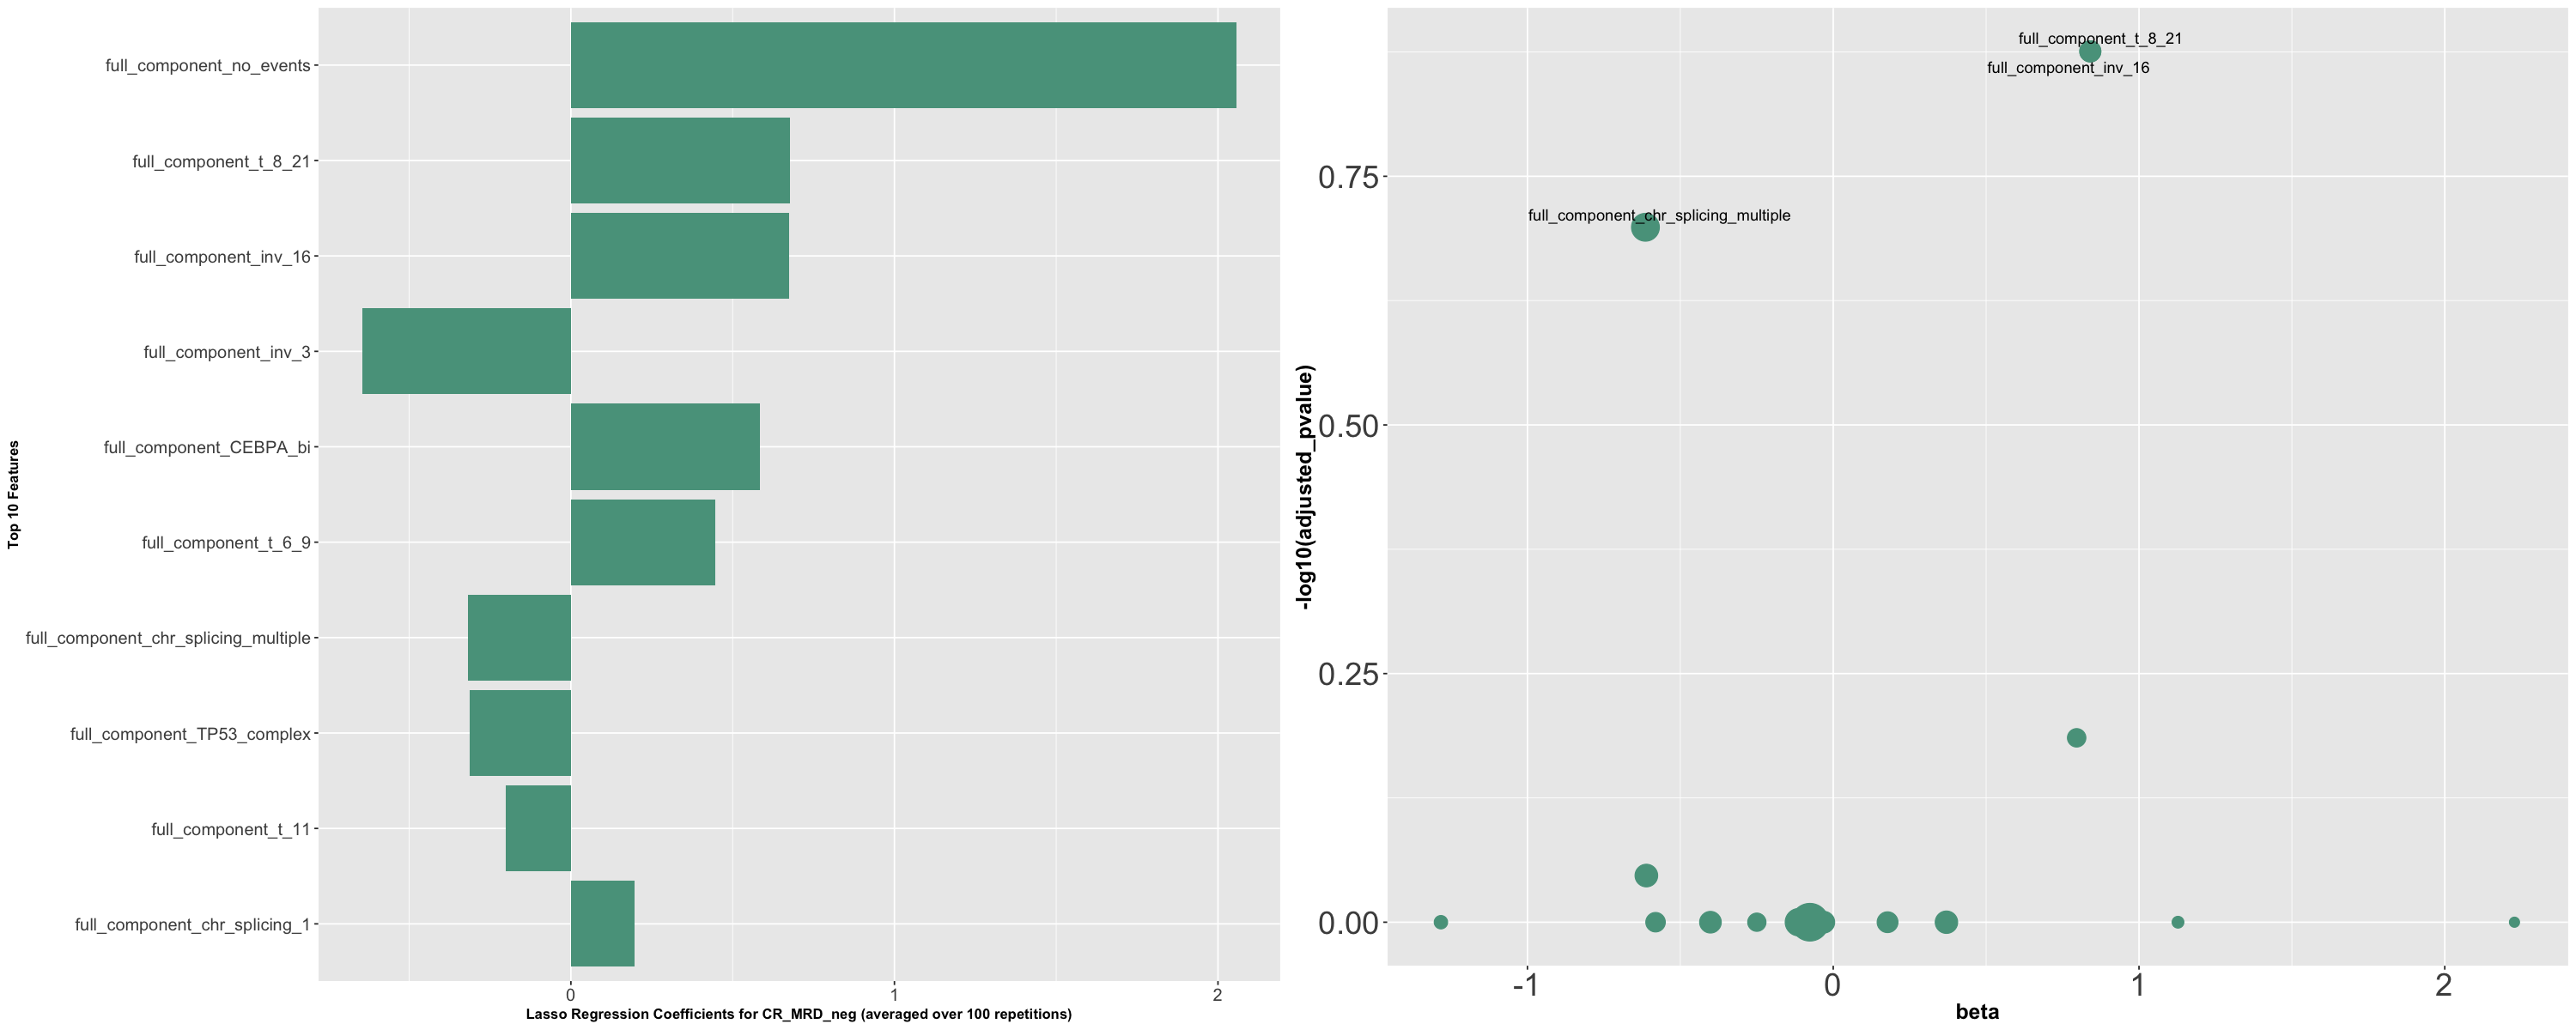

In [75]:
set_notebook_plot_size(25,10)
p <- multivariate_regression(df_merge,"CR_MRD_neg",features=c(comp),fam="binomial",num_iterations = 100,size_title=10)
q <- univariate_volcano(df_merge,"CR_MRD_neg",features=c(comp),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=15,legend.position="none")
grid.arrange(p,q,nrow=1)

In [76]:
png("mrd_pc2_negative_components.png",width=7000,height=3550,res=420)
grid.arrange(p,q,nrow=1)
dev.off()

pdf 
  2

# 2) Genes and Cytos

# A) Association rules learning

In [104]:
tmp <- df_merge[,c(gen,cyto,"CR_MRD_neg")]
tmp$no_CR_MRD_neg <- ifelse(tmp$CR_MRD_neg==0,1,0)
tmp$CR_MRD_neg <- NULL
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{no_CR_MRD_neg}" & ruledf$lift >1 & ruledf$confidence >=0.9,]
colnames(ruledf)[colnames(ruledf) %in% c("lhs","rhs")] <- c("Rules","Target")


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[50 item(s), 744 transaction(s)] done [0.00s].
sorting and recoding items ... [49 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 done [0.00s].
writing ... [403 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [105]:
ruledf[order(ruledf$support,decreasing=T),]

,Rules,Target,support,confidence,lift,count
64,{TP53},{no_CR_MRD_neg},0.05241935,0.9285714,1.231474,39
214,"{complex,TP53}",{no_CR_MRD_neg},0.04301075,0.9142857,1.212529,32
246,"{SRSF2,TET2}",{no_CR_MRD_neg},0.02419355,0.9000000,1.193583,18
269,"{NRAS_p.G12_13,TET2}",{no_CR_MRD_neg},0.02284946,1.0000000,1.326203,17
185,"{ASXL1,SRSF2}",{no_CR_MRD_neg},0.01747312,0.9285714,1.231474,13
187,"{ASXL1,TET2}",{no_CR_MRD_neg},0.01478495,0.9166667,1.215686,11
230,"{add_8,RUNX1}",{no_CR_MRD_neg},0.01478495,0.9166667,1.215686,11
374,"{DNMT3A,NRAS_p.G12_13,TET2}",{no_CR_MRD_neg},0.01478495,1.0000000,1.326203,11
126,"{add_22,complex}",{no_CR_MRD_neg},0.01344086,0.9090909,1.205639,10
211,"{del_7,RUNX1}",{no_CR_MRD_neg},0.01344086,1.0000000,1.326203,10


In [102]:
tmp <- df_merge[,c(gen,cyto,"CR_MRD_neg")]
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{CR_MRD_neg}",]
colnames(ruledf)[colnames(ruledf) %in% c("lhs","rhs")] <- c("Rules","Target")


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[50 item(s), 744 transaction(s)] done [0.00s].
sorting and recoding items ... [49 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [147 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [103]:
ruledf[order(ruledf$count,decreasing=T),]

,Rules,Target,support,confidence,lift,count
45,"{minusy,t_8_21}",{CR_MRD_neg},0.01344086,0.5882353,2.404654,10


# B) Univariate and Multivariate Regression

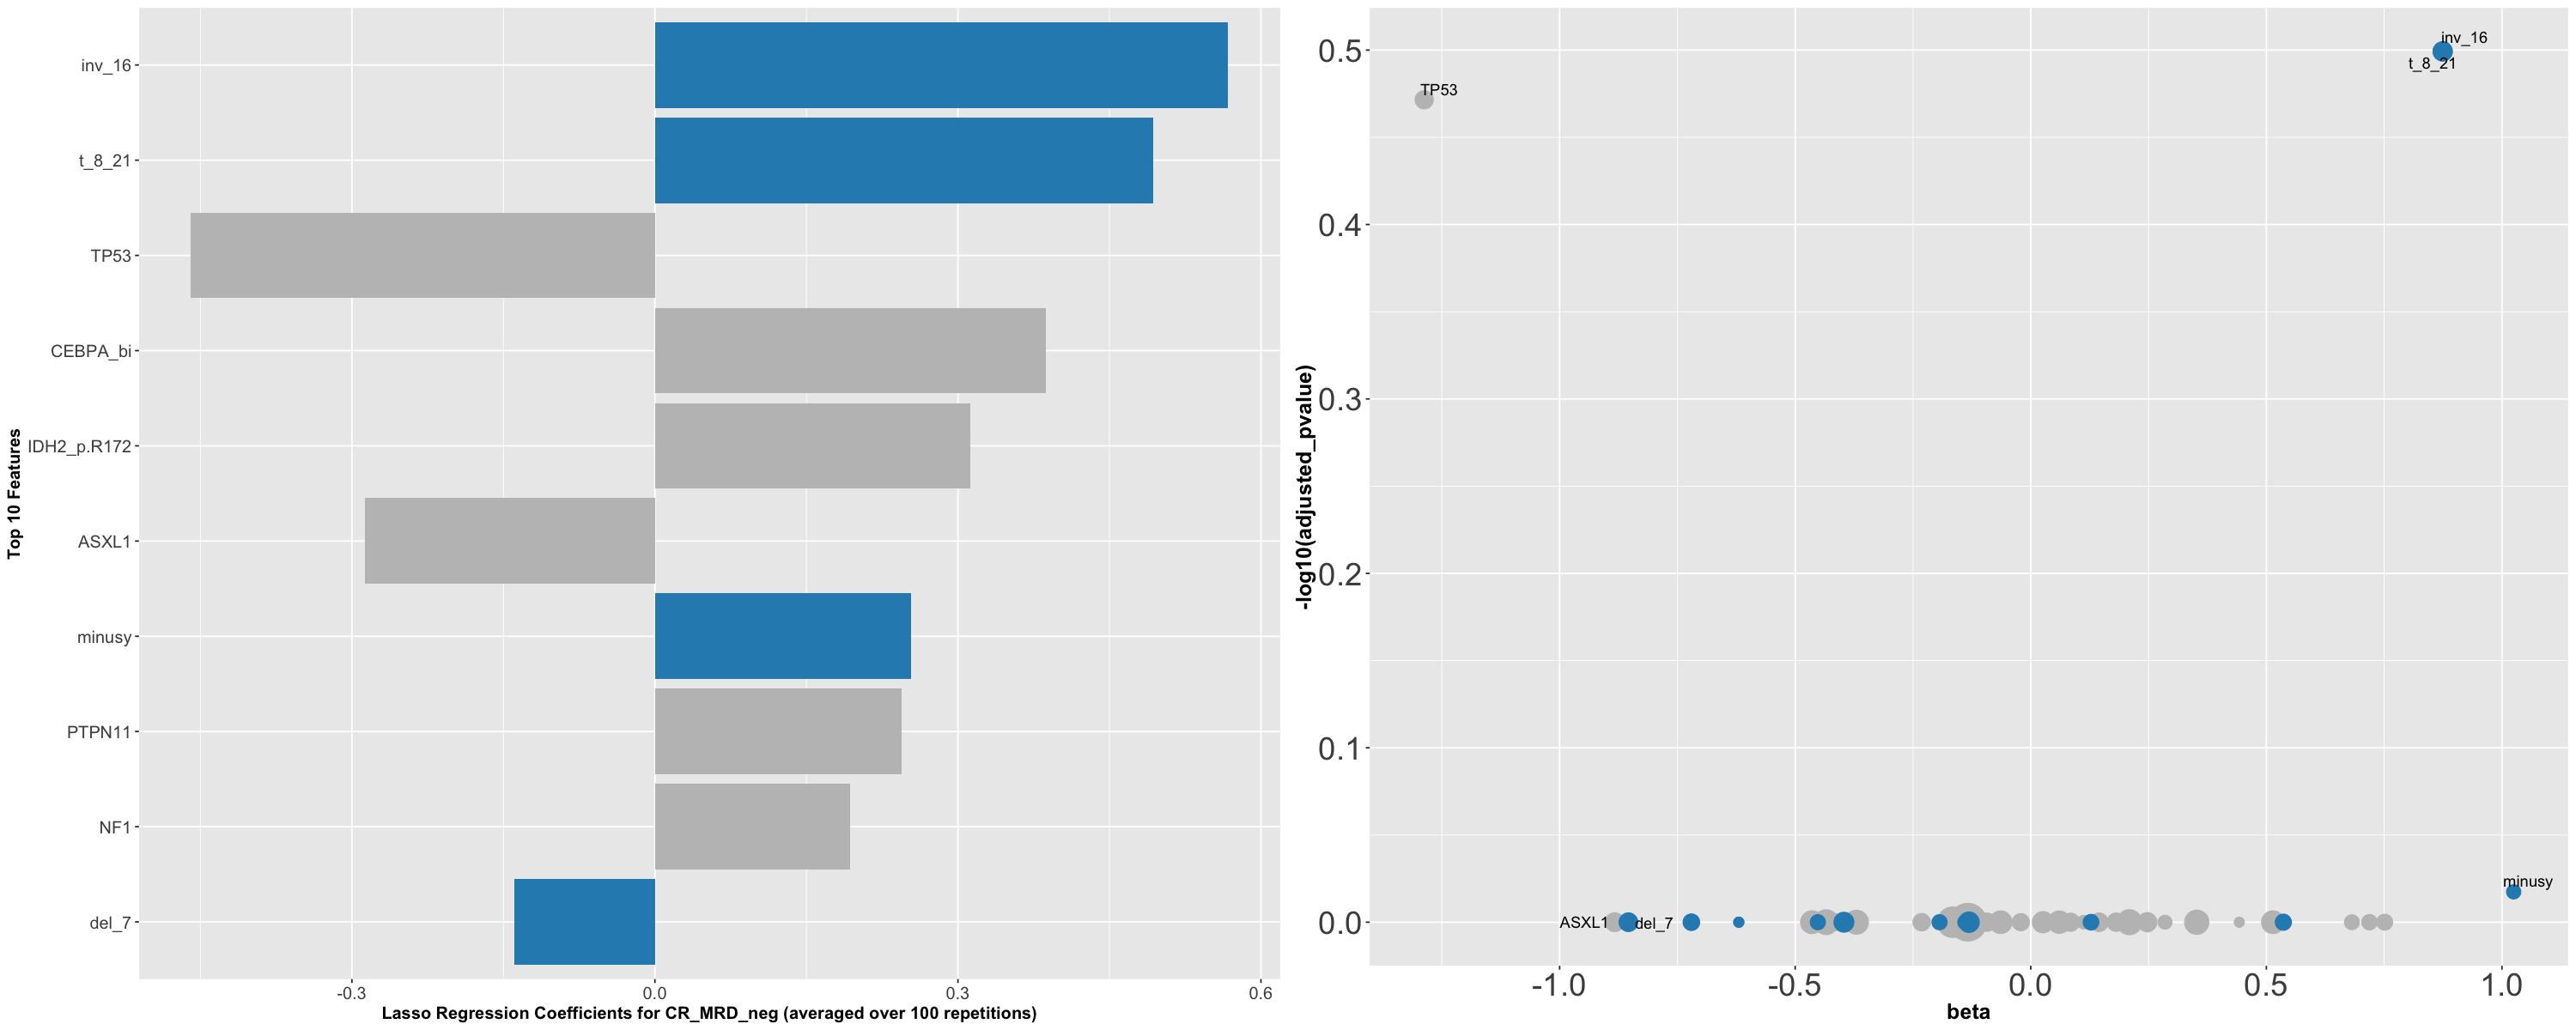

In [21]:
set_notebook_plot_size(25,10)
p <- multivariate_regression(df_merge,"CR_MRD_neg",features=c(gen,cyto),fam="binomial",num_iterations = 100,size_title=12,top_n=10)
q <- univariate_volcano(df_merge,"CR_MRD_neg",features=c(gen,cyto),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=15,legend.position="none")
grid.arrange(p,q,nrow=1) 

In [22]:
png("mrd_negative_pc2_genes.png",width=7000,height=3550,res=420)
grid.arrange(p,q,nrow=1)
dev.off()

pdf 
  2

# 3) Molecular, clinical and demographic

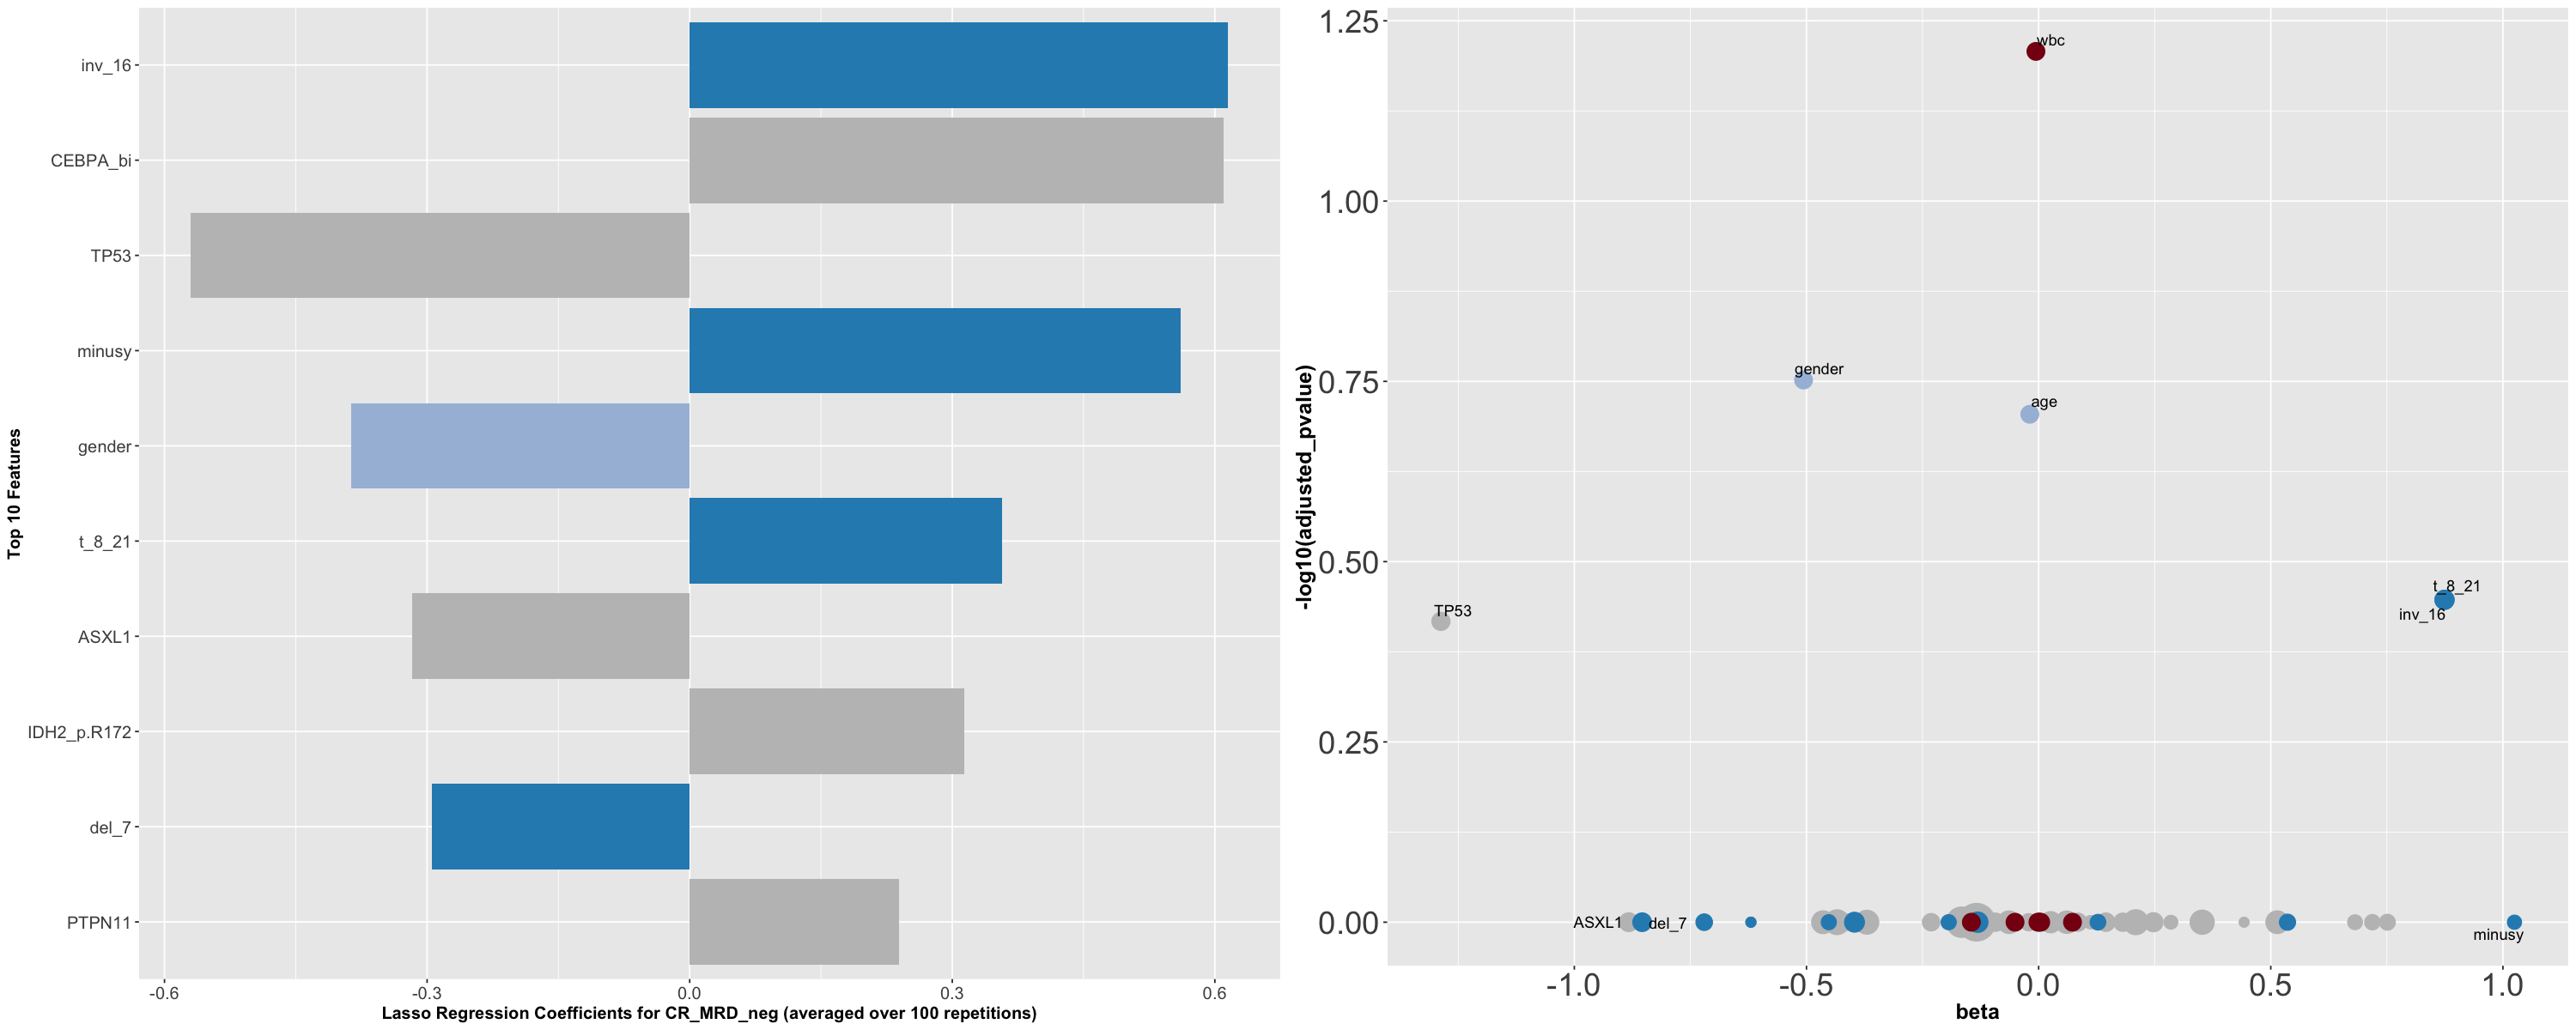

In [23]:
set_notebook_plot_size(25,10)
p <- multivariate_regression(df_merge,"CR_MRD_neg",features=c(gen,cyto,clin,demo),fam="binomial",num_iterations = 100,size_title=12)
q <- univariate_volcano(df_merge,"CR_MRD_neg",features=c(gen,cyto,clin,demo),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=15,legend.position="none")
grid.arrange(p,q,nrow=1)

In [24]:
png("mrd_negative_pc2_all.png",width=7000,height=3550,res=420)
grid.arrange(p,q,nrow=1)
dev.off()

pdf 
  2

# II) MRD Positive Predictors

# 1) Components

# A) Association rules learning

In [25]:
tmp <- df_merge[,c(comp,"CR_MRD_pos")]
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{CR_MRD_pos}",]


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[19 item(s), 720 transaction(s)] done [0.00s].
sorting and recoding items ... [14 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [16 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [26]:
ruledf[order(ruledf$count,decreasing=T),]

lhs,rhs,support,confidence,lift,count


# B) Univariate and Multivariate Regression

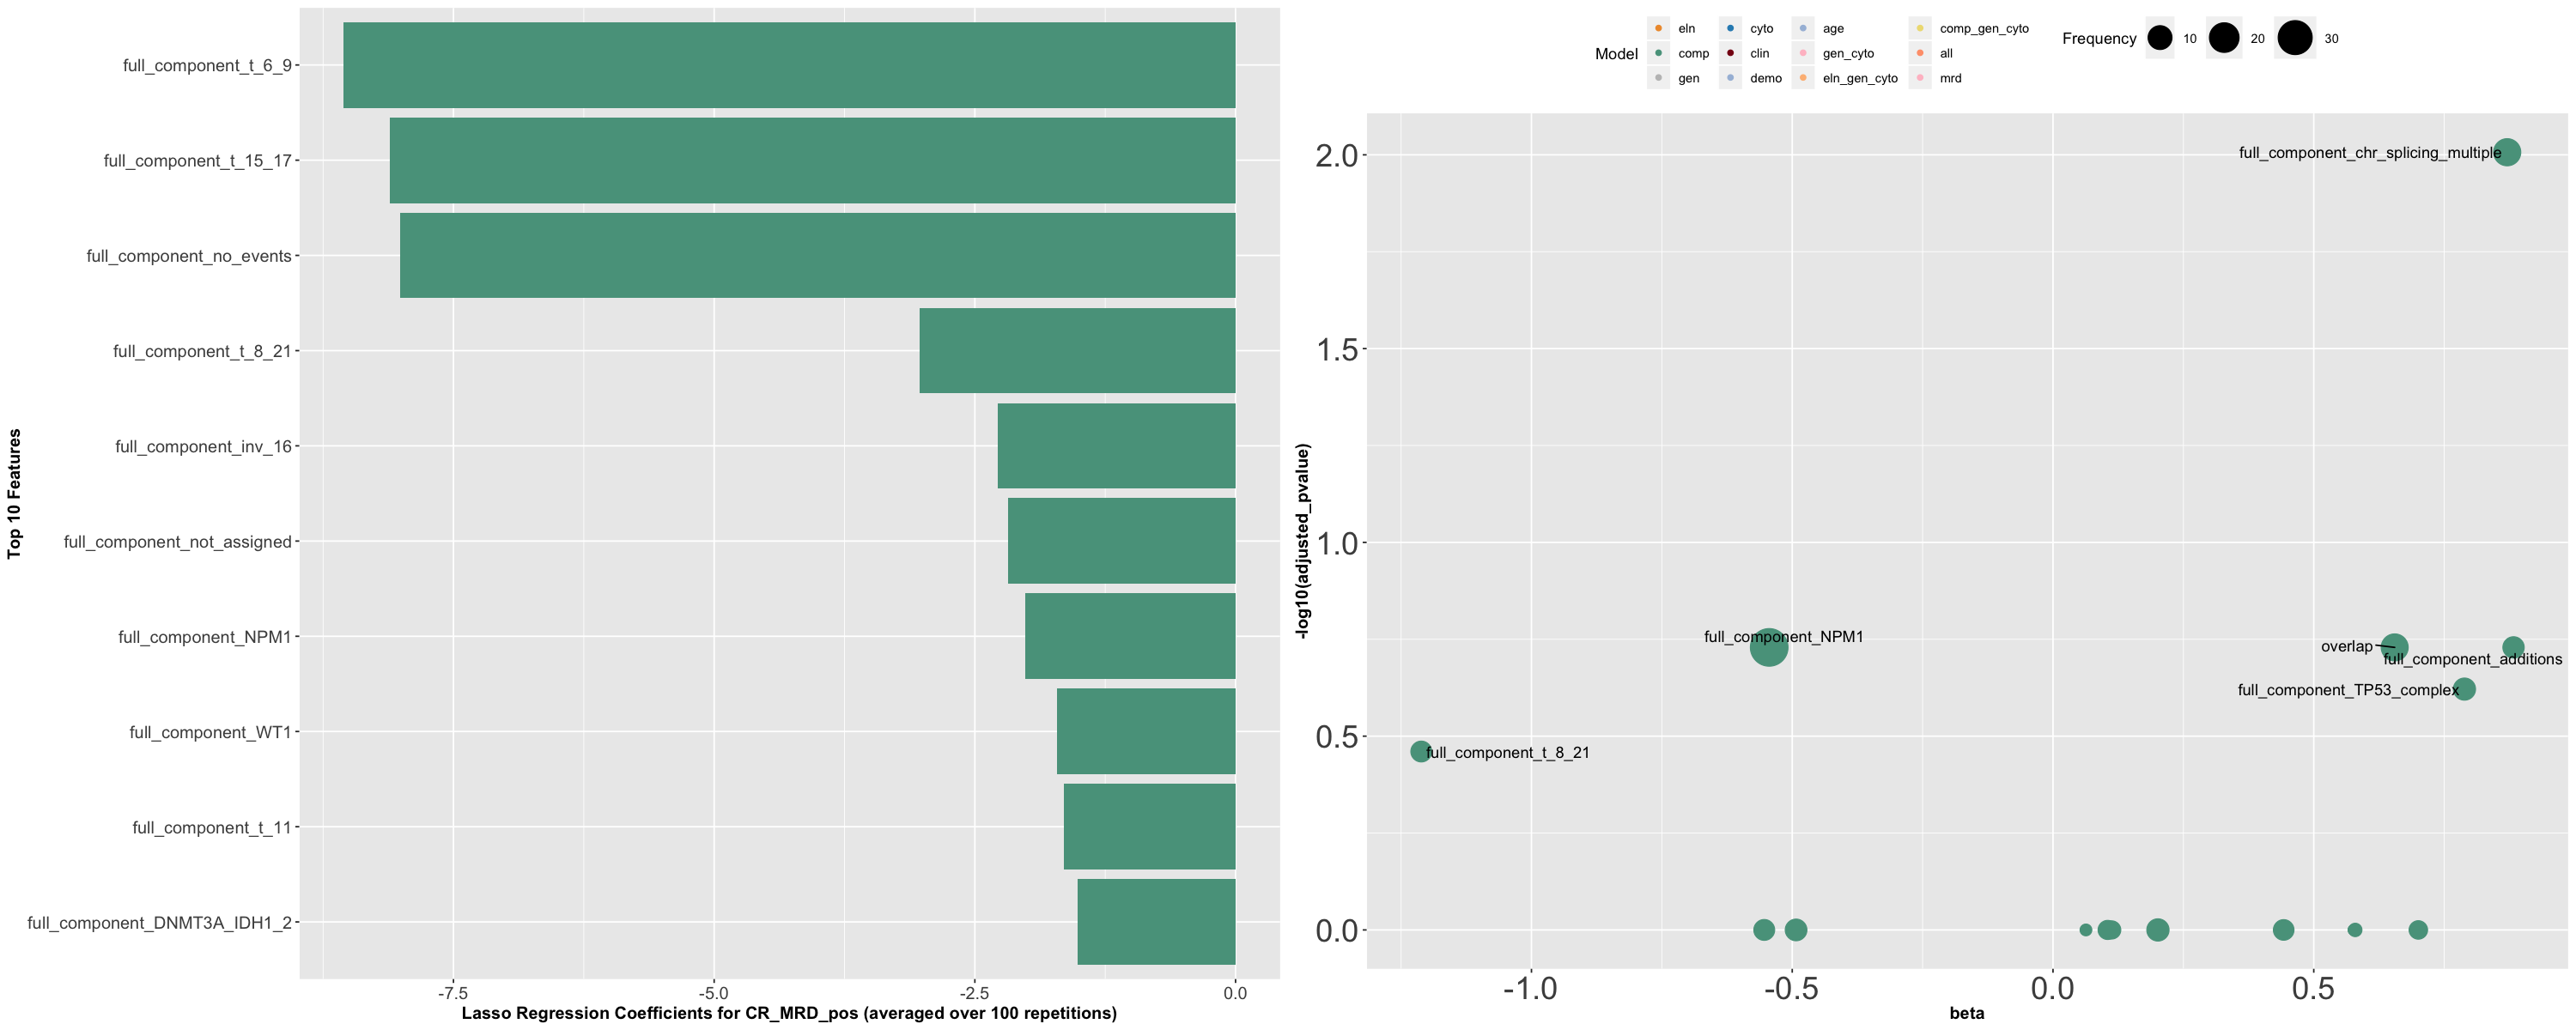

In [27]:
set_notebook_plot_size(25,10)
p <- multivariate_regression(df_merge,"CR_MRD_pos",features=c(comp),fam="binomial",num_iterations = 100,lambda=c(0,0.00001),size_title=12,size_axis = 12)
q <- univariate_volcano(df_merge,"CR_MRD_pos",features=c(comp),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=12)
grid.arrange(p,q,nrow=1)

# 2) Genes and Cytos

# A) Association rules learning

In [28]:
tmp <- df_merge[,c(gen,cyto,"CR_MRD_pos")]
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.008, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{CR_MRD_pos}",]


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5   0.008      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 5 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[49 item(s), 720 transaction(s)] done [0.00s].
sorting and recoding items ... [48 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 done [0.00s].
writing ... [229 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [29]:
ruledf[order(ruledf$count,decreasing=T),]

lhs,rhs,support,confidence,lift,count


In [30]:
# Not enough confidence !

# B) Univariate and Multivariate Regression

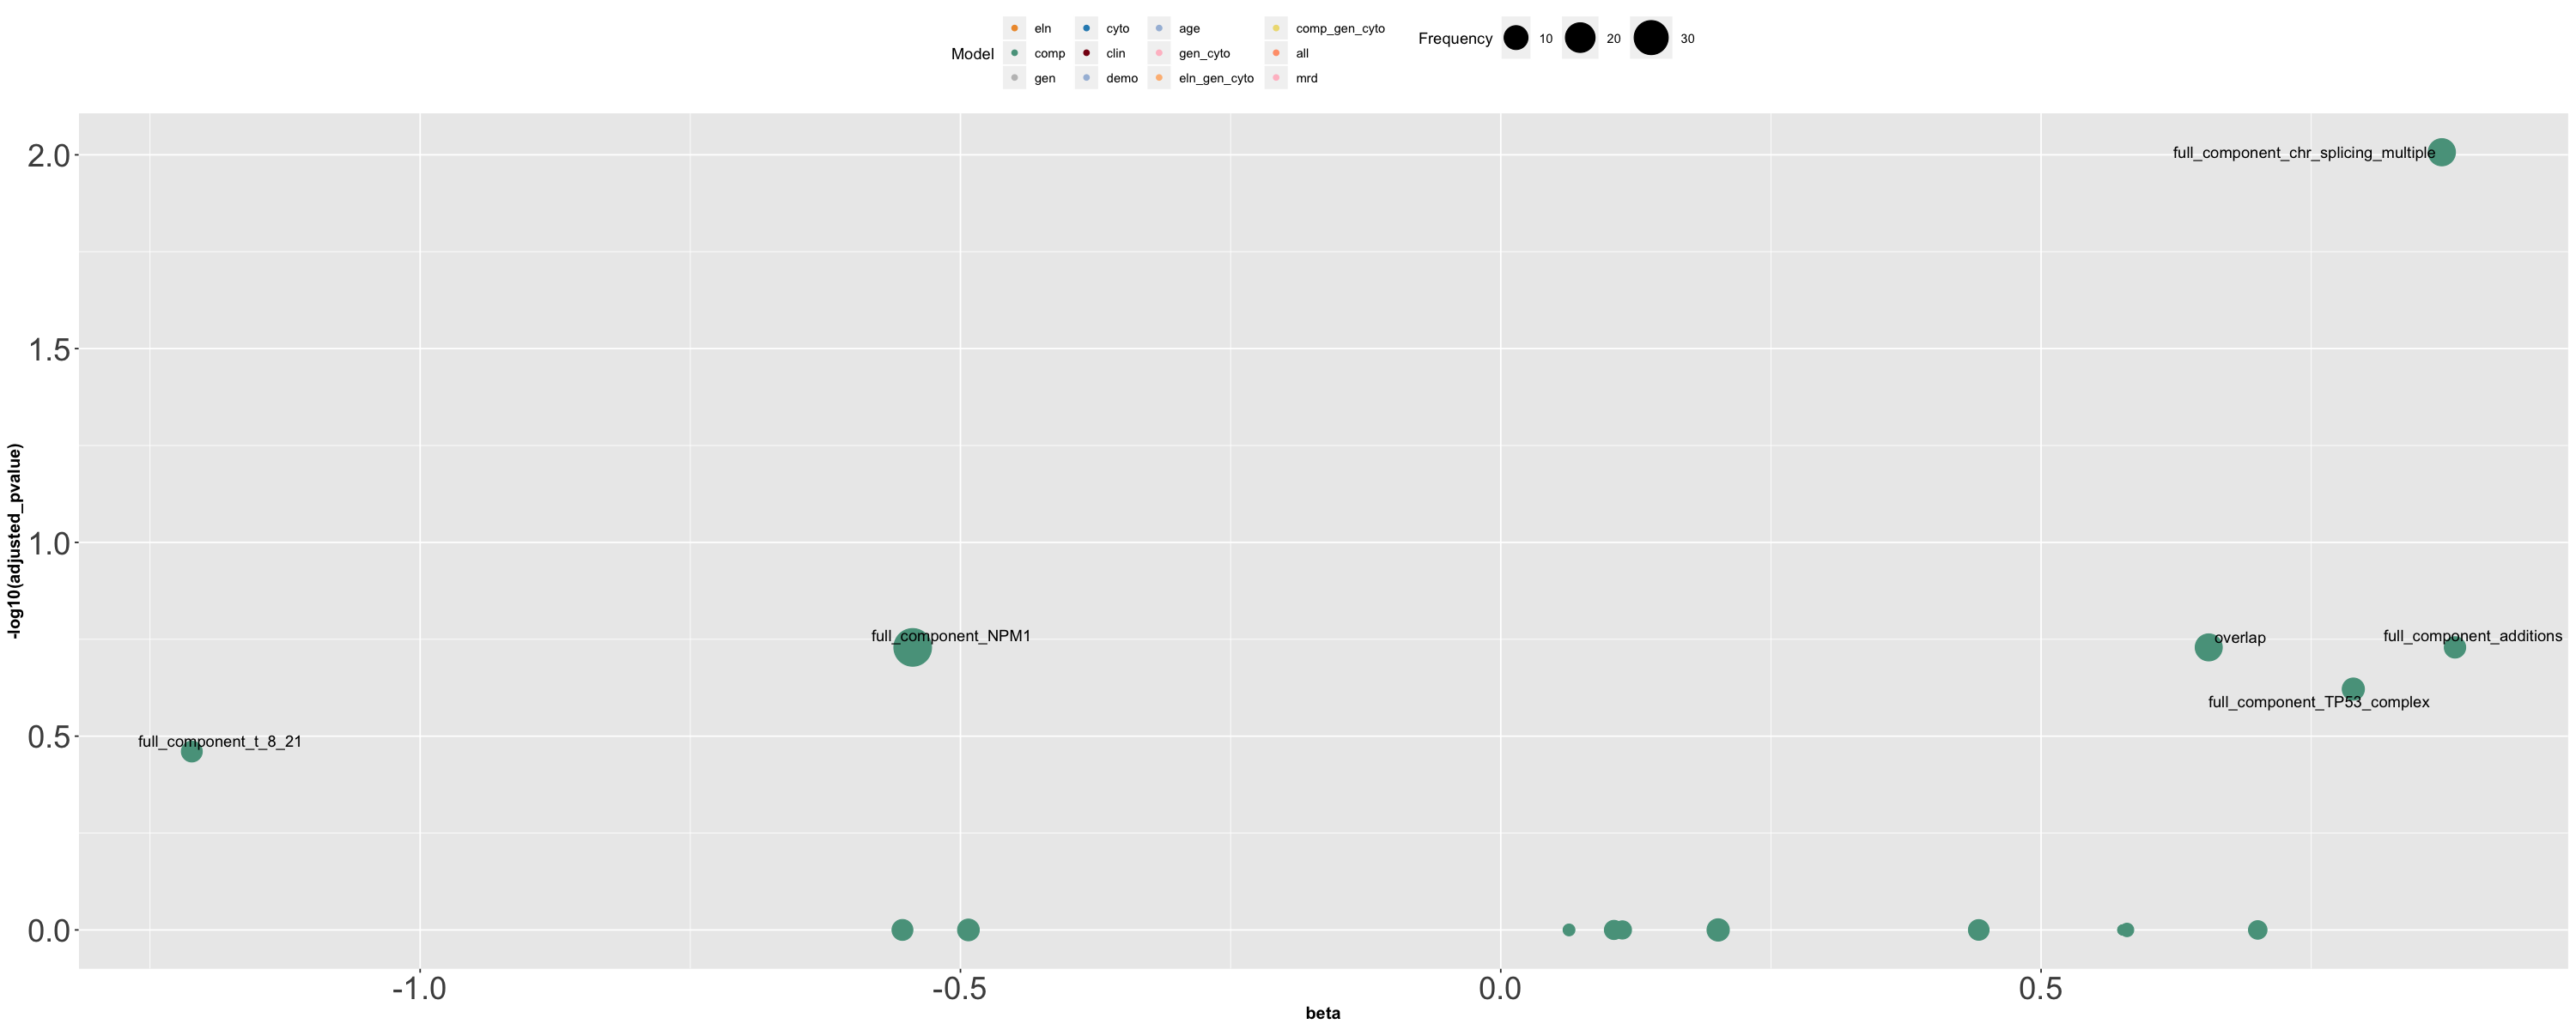

In [31]:
q

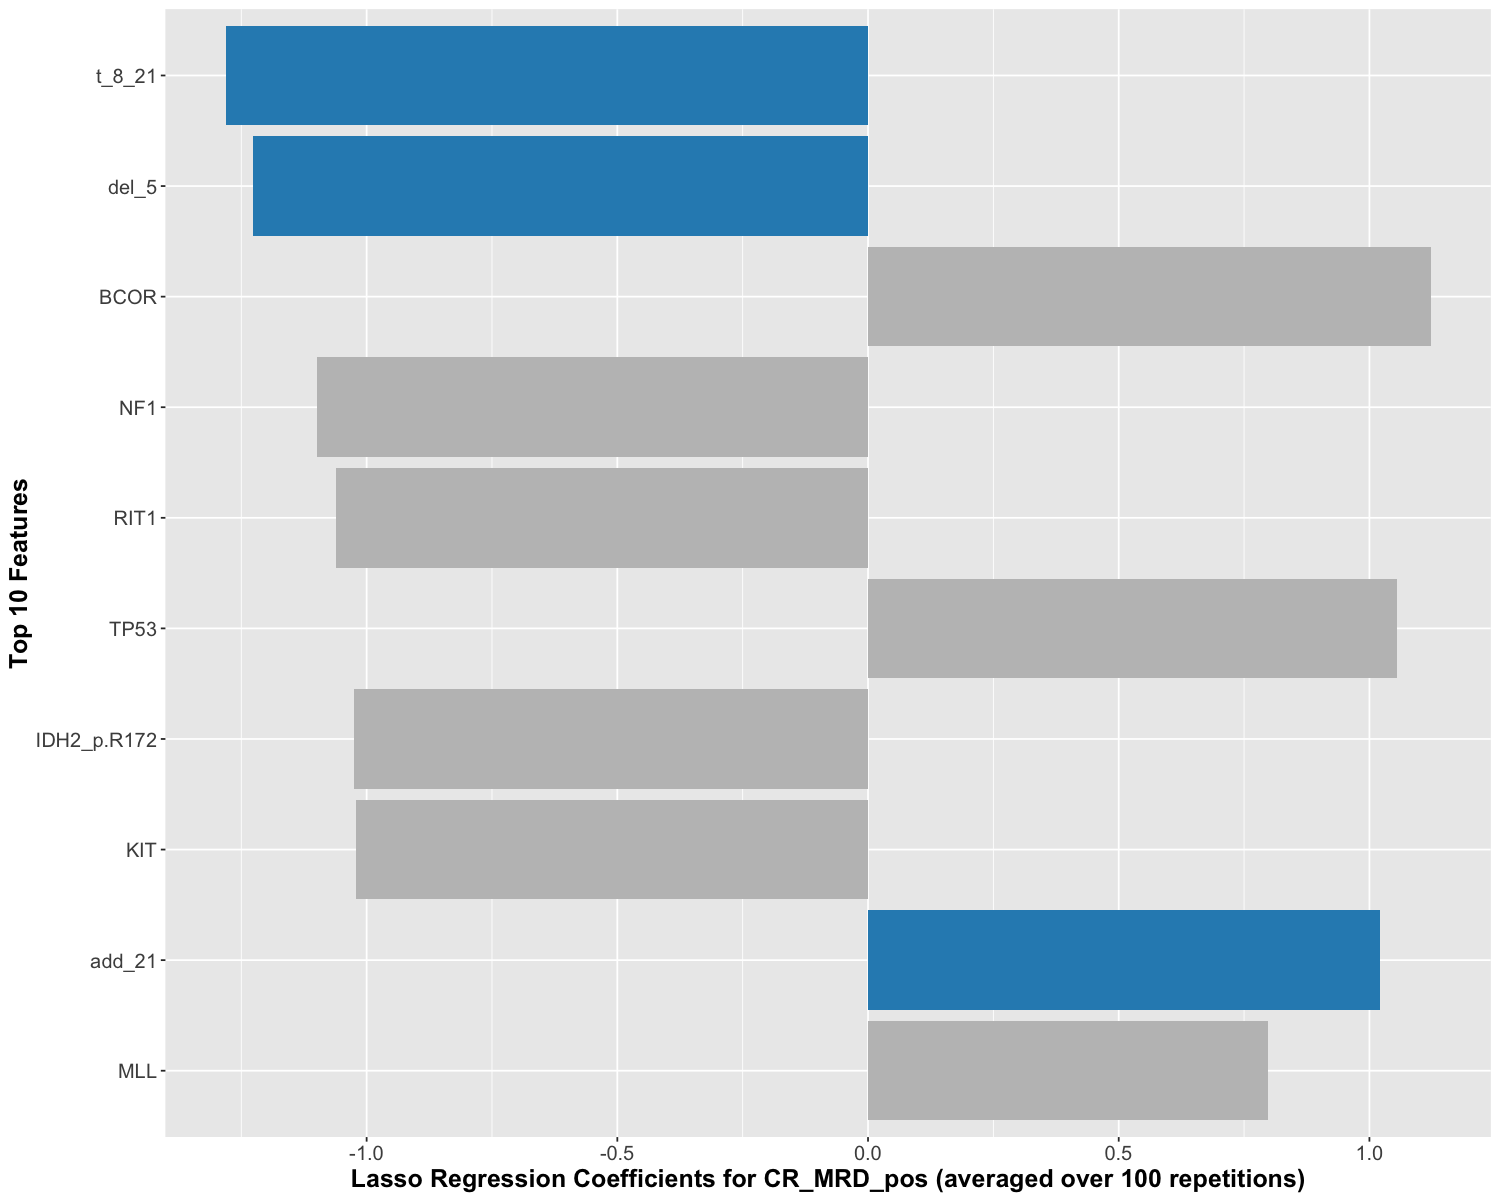

In [32]:
set_notebook_plot_size(12.5,10)
p <- multivariate_regression(df_merge,"CR_MRD_pos",features=c(gen,cyto),fam="binomial",num_iterations = 100,lambda=c(0,0.00001),size_title=15)
q <- univariate_volcano(df_merge,"CR_MRD_pos",features=c(gen,cyto),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=15)
p

# III ) MRD Impact on End Points


In [33]:
colors_analysis <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",gen_cyto="pink",eln_gen_cyto="#fdbb84",comp_gen_cyto="lightgoldenrod",all="lightsalmon",mrd="pink")

# III.1) RFS

In [46]:
    ## Volcano Plot Univariate
    
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- df_merge

for (col in c(gen,cyto,mrd,clin,demo)){
    surv_object <- Surv(time = data$RFSyears, event = data$RFSStatus)
    fit <- coxph(as.formula(paste("Surv(RFSyears,RFSStatus) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% gen,"gen",
                  ifelse(df$names %in% cyto,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln",
                                           ifelse(df$names %in% mrd, "mrd","comp"))))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.05) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot
   # we can not run lasso on a model without any events (variance 0)
data <- df_merge
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c(gen,cyto,mrd,clin,demo)]), Surv(data$RFSyears,data$RFSStatus), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln, "eln",
                                       ifelse(l$names %in% mrd, "mrd","comp"))))))
l$abs_coef <- abs(l$coef)

t <- ggplot(l[l$coef!=0,],aes(x=reorder(names,abs_coef),y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=14),axis.title=element_text(size=14,face="bold"))+
scale_fill_manual(values=colors_analysis,limits=names(colors_analysis)) + theme(legend.position="none")+ xlab("")



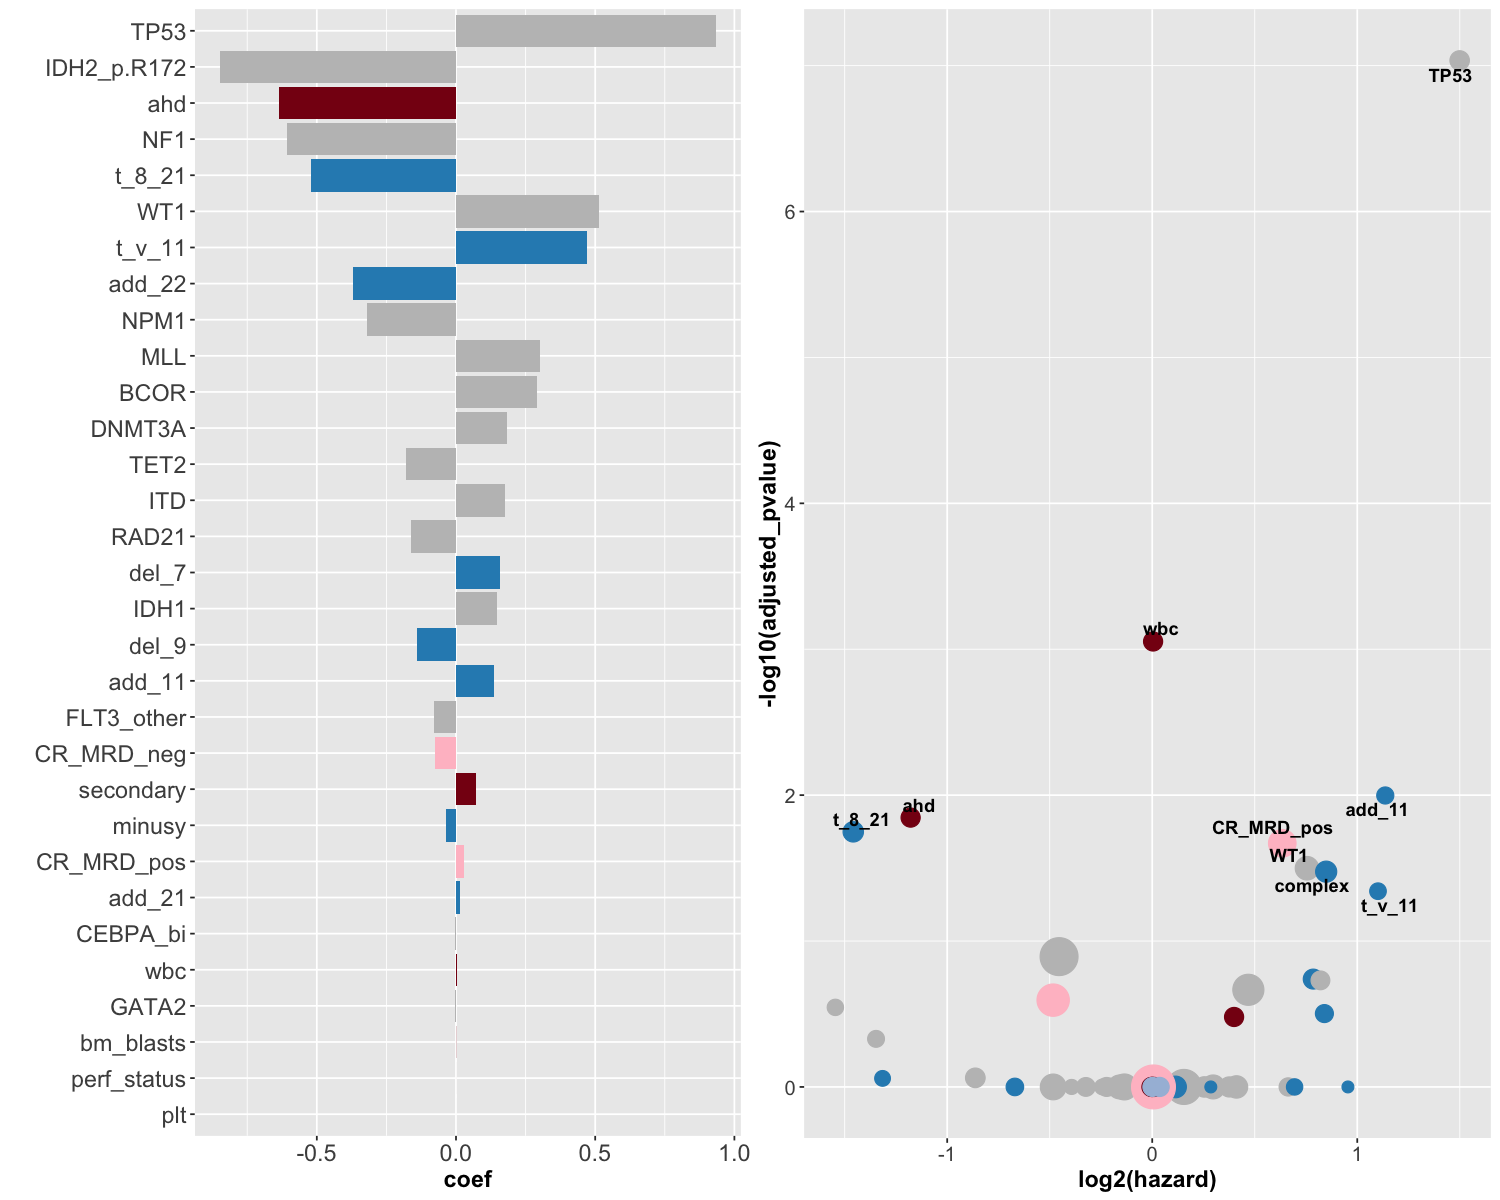

In [35]:
grid.arrange(t,s,nrow=1)

In [36]:
png("rfs_pc2.png",width=7000,height=3550,res=350)
grid.arrange(t,s,nrow=1)
dev.off()

pdf 
  2

# III.2) OS_CR

In [41]:
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- df_merge

for (col in c(gen,cyto,mrd,clin,demo)){
    surv_object <- Surv(time = data$OS_CR, event = data$DEADStatus)
    fit <- coxph(as.formula(paste("Surv(OS_CR,DEADStatus) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% gen,"gen",
                  ifelse(df$names %in% cyto,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln",
                                           ifelse(df$names %in% mrd, "mrd","comp"))))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.05) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot
   # we can not run lasso on a model without any events (variance 0)
data <- df_merge
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c(gen,cyto,mrd,clin,demo)]), Surv(data$OS_CR,data$DEADStatus), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln, "eln",
                                       ifelse(l$names %in% mrd, "mrd","comp"))))))
l$abs_coef <- abs(l$coef)
t <- ggplot(l[l$coef!=0,],aes(x=reorder(names,abs_coef),y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=14),axis.title=element_text(size=14,face="bold"))+
scale_fill_manual(values=colors_analysis,limits=names(colors_analysis)) + theme(legend.position="none")+xlab("")



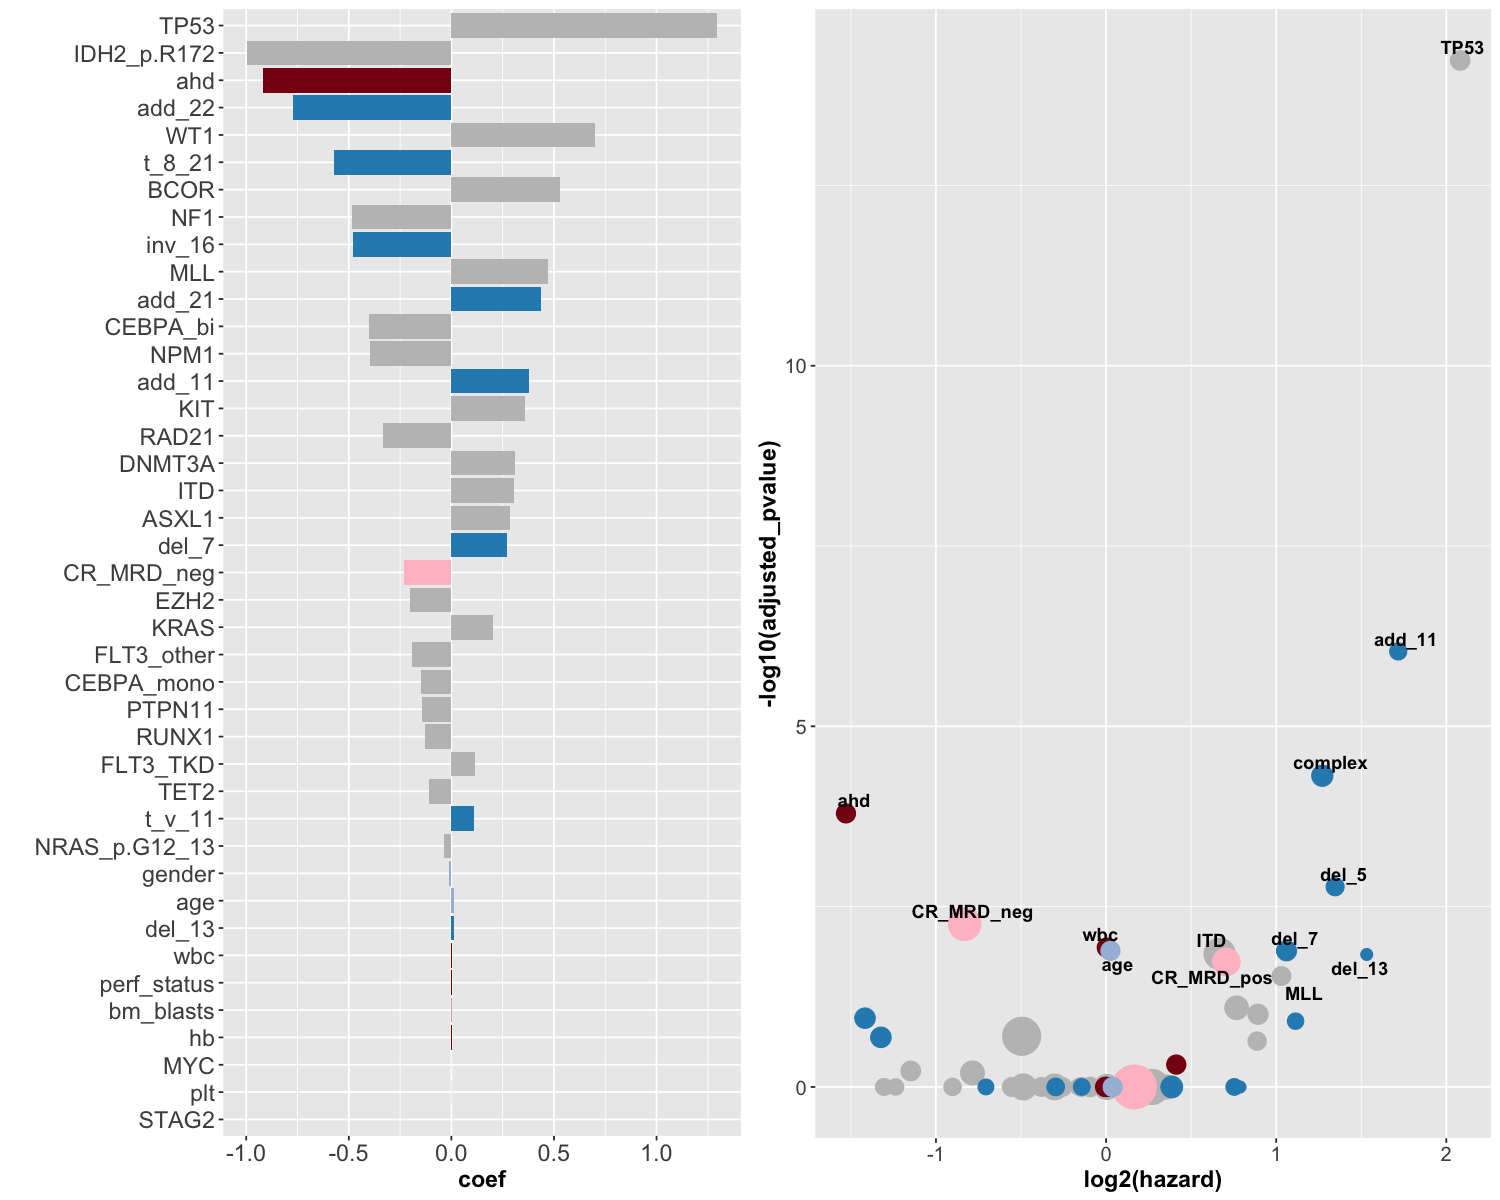

In [42]:
grid.arrange(t,s,nrow=1)

In [43]:
png("os_cr_pc2.png",width=7000,height=3550,res=350)
grid.arrange(t,s,nrow=1)
dev.off()

pdf 
  2

In [47]:
l

,coef,names,Model,abs_coef
ASXL1,0.000000e+00,ASXL1,gen,0.000000e+00
BCOR,2.924870e-01,BCOR,gen,2.924870e-01
CEBPA_bi,-3.713351e-03,CEBPA_bi,gen,3.713351e-03
CEBPA_mono,0.000000e+00,CEBPA_mono,gen,0.000000e+00
DNMT3A,1.860278e-01,DNMT3A,gen,1.860278e-01
EZH2,0.000000e+00,EZH2,gen,0.000000e+00
ITD,1.763272e-01,ITD,gen,1.763272e-01
FLT3_TKD,0.000000e+00,FLT3_TKD,gen,0.000000e+00
FLT3_other,-8.245204e-02,FLT3_other,gen,8.245204e-02
GATA2,-3.069199e-03,GATA2,gen,3.069199e-03


# III.3) OS

In [38]:
    ## Volcano Plot Univariate
    
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- df_merge

for (col in c(gen,cyto,mrd,clin,demo)){
    surv_object <- Surv(time = data$os, event = data$os_status)
    fit <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% gen,"gen",
                  ifelse(df$names %in% cyto,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln",
                                           ifelse(df$names %in% mrd, "mrd","comp"))))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.1) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot
   # we can not run lasso on a model without any events (variance 0)
data <- df_merge
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c(gen,cyto,mrd,clin,demo)]), Surv(data$os,data$os_status), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln, "eln",
                                       ifelse(l$names %in% mrd, "mrd","comp"))))))
l$abs_coef <- abs(l$coef)
t <- ggplot(l[l$coef!=0,],aes(x=reorder(names,abs_coef),y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=14),axis.title=element_text(size=14,face="bold"))+
scale_fill_manual(values=colors_analysis,limits=names(colors_analysis)) + theme(legend.position="none")+xlab("")



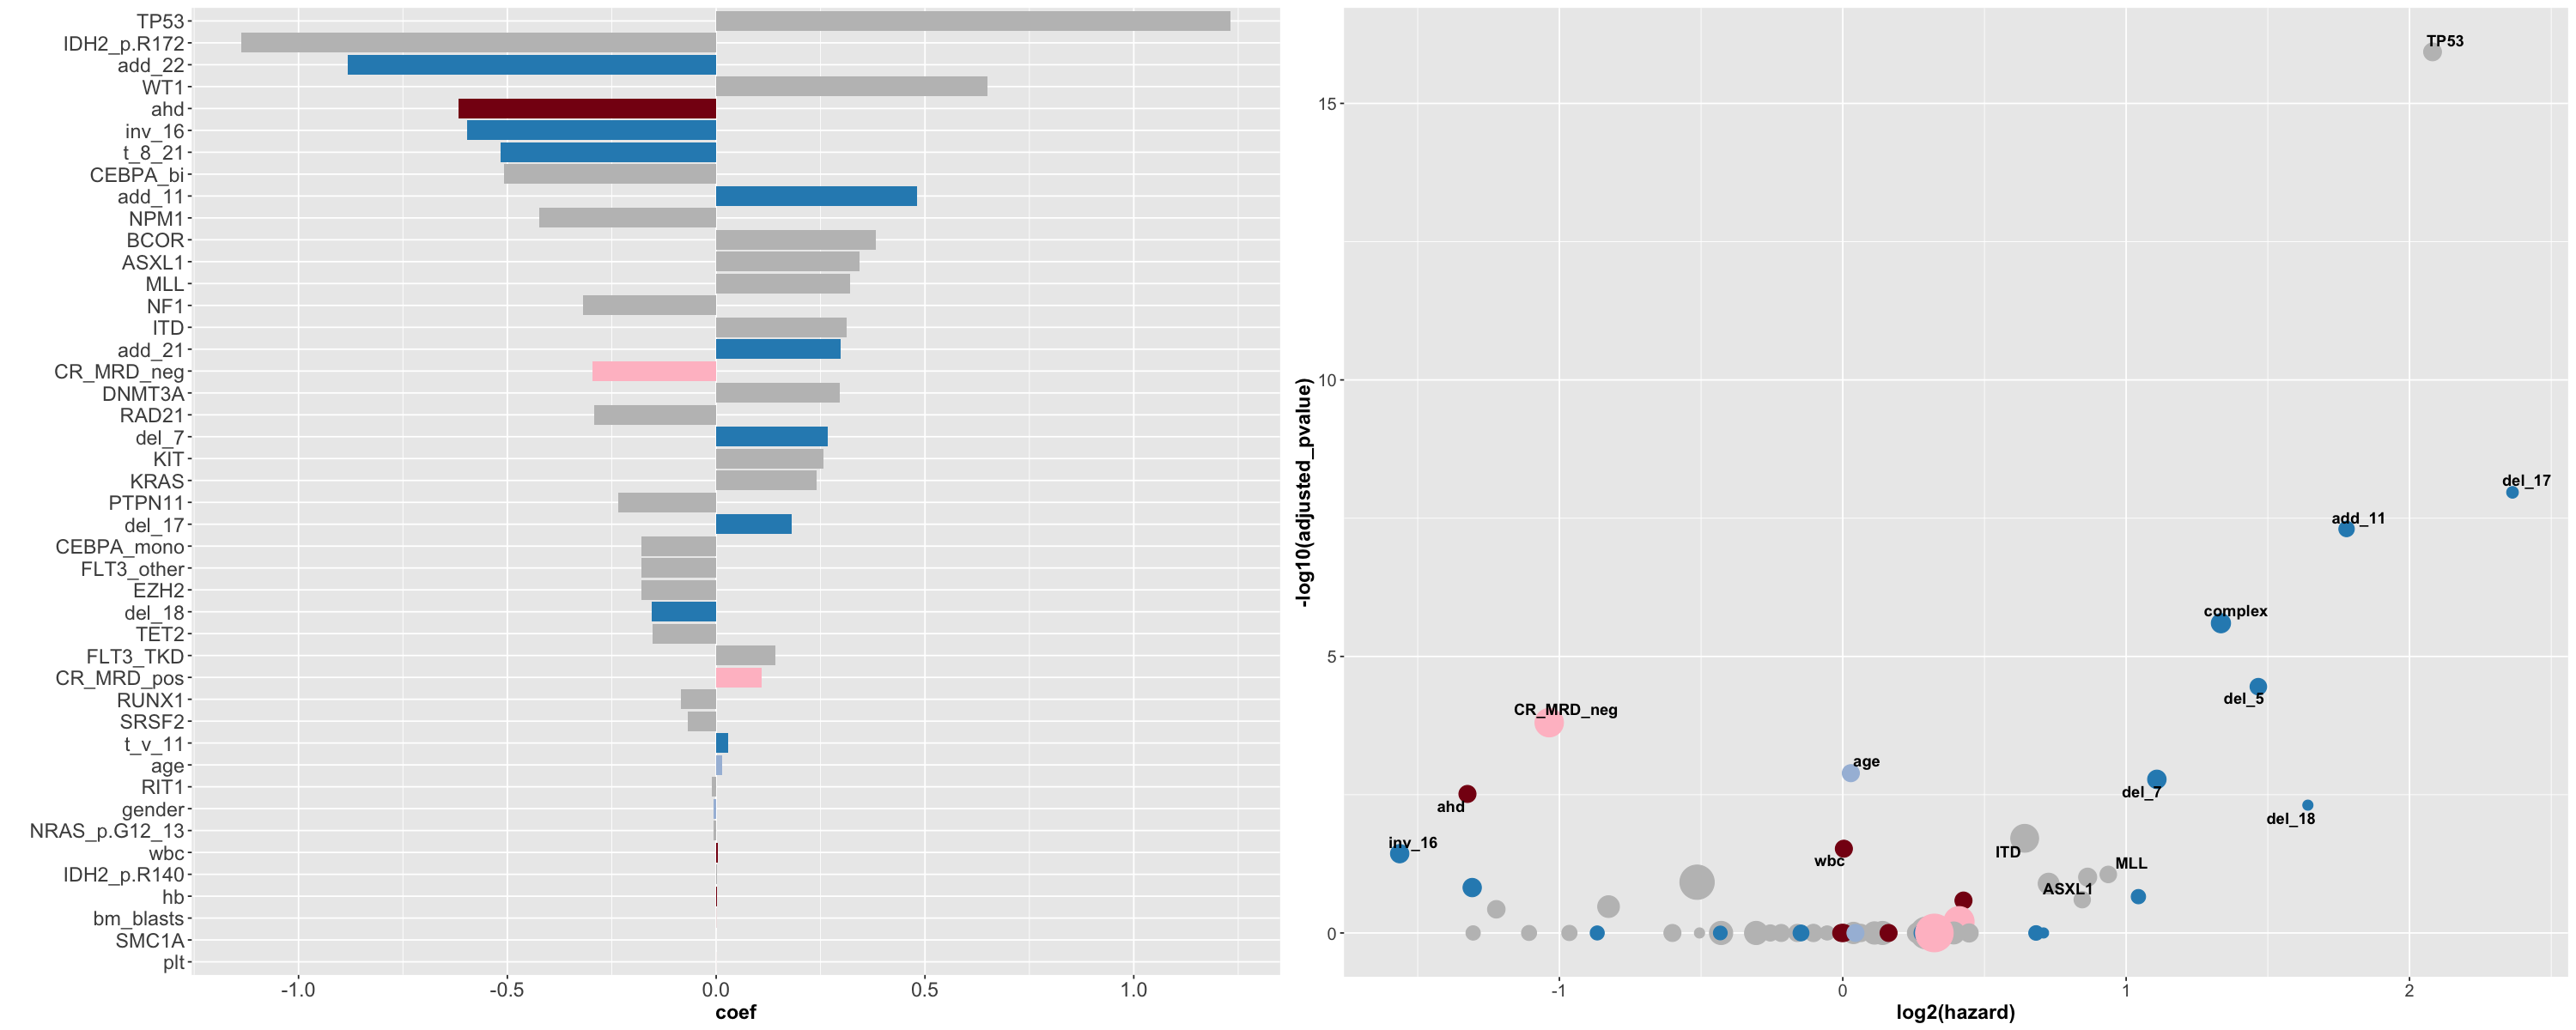

In [39]:
grid.arrange(t,s,nrow=1)

In [41]:
png("os.png",width=7000,height=3550,res=350)
grid.arrange(t,s,nrow=1)
dev.off()

pdf 
  2

In [ ]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,cols_to_keep],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("17-", df_merge$AMLID),]   ### keep only AML 17
df_merge$CR_MRD_neg <- ifelse(df_merge$MRD1=="CR,MRD-",1,0)
df_merge$CR_MRD_pos <- ifelse(df_merge$MRD1=="CR,MRD+",1,0)
df_merge$all_others <- ifelse(df_merge$MRD1!="CR,MRD+" & df_merge$MRD1!="CR,MRD-",1,0)
df_merge <- df_merge[!is.na(df_merge$OS_CR),]
df_merge <- df_merge[!is.na(df_merge$MRD1),]
df_merge <- df_merge[df_merge$os >0 & df_merge$OS_CR >0 & df_merge$RFSyears>0,]

In [111]:
read <- read.table("../handovercompiled.Yanis.080919.csv",sep=",",header = T)

In [119]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,cols_to_keep],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("17-", df_merge$AMLID),] 

In [143]:
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
master$AMLID <- as.character(master$AMLID)
master <- master[grep("16-", master$AMLID),] 
table(master$MRD1)


CR no MRD data        CR,MRD-        CR,MRD+           MRD-           MRD+ 
             0              0              0             19             24 
         no CR     No CR data    No MRD data      Not in CR             PR 
             0              0             48             74              0 
            RD 
             0 

In [144]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,cols_to_keep],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("16-", df_merge$AMLID),] 
table(df_merge$MRD1)


       MRD-        MRD+ No MRD data   Not in CR 
         17          22          40          53 

In [149]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
table(tmp$RFSStatus)


   0    1 
 530 1364 

In [150]:
head(tmp)

donor_id,data_pd,sample_pd.x,date_entry,trtcode,AMLID,dead60,MRDgp1,MRDgp2,CRby1,⋯,RelapseCIStatus,DaystoFirstCR,CODCause,OS_CR,CRdate,randDate_PB,CRDate_PB,relapseDate_PB,boneDate_PB,longCR_PB
16-1065,PD20150a,PD20150a,1/22/2007,160031,16-1065,0,1,0,No,⋯,2,99,OTHER CANCER,4.405202,5/1/2007,0,0,0,0,0
16-1079,PD15295c,PD15295c,2/22/2007,160004,NA,NA,NA,NA,NA,⋯,2,32,GVHD,2.173854,3/26/2007,0,0,0,0,0
16-1083,PD20149c,PD20149c,2/3/2007,160003,16-1083,0,0,0,No,⋯,1,122,RECURRENT LEUK,4.030116,7/2/2007,0,0,0,0,0
16-1095,PD15248c,PD15248c,3/22/2007,160037,16-1095,0,0,0,Yes,⋯,1,39,RECURRENT LEUK,1.158111,4/30/2007,0,0,0,0,0
16-1110,PD15260c,PD15260c,12/4/2007,160002,16-1110,0,0,0,Yes,⋯,1,39,RECURRENT LEUK,2.069815,5/21/2007,0,0,0,0,0
16-1113,PD20148c,PD20148c,4/17/2007,160073,16-1113,0,2,0,Yes,⋯,1,28,39,2.220397,5/15/2007,0,0,0,0,0


In [153]:
table(tmp$RelapseCIStatus)


  0   1   2 
530 712 652 